# The ARCO-ERA5 dataset - exploration

The ARCO-ERA5 dataset is a dataset of hourly weather data for the years 2010-2019. It is based on the ERA5 reanalysis data from the European Centre for Medium-Range Weather Forecasts (ECMWF). The dataset is available for free, hosted by Google: https://github.com/google-research/arco-era5

In [1]:
# Install xarray and co
%pip install -q xarray pandas zarr netcdf4 bottleneck fsspec


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install Google requirements
%pip install -q gcsfs


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Install plotting requirements
%pip install -q matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta

In [5]:
# Load the dataset
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)

In [6]:
# Define the past 2 weeks' time range
start_time = pd.Timestamp('2018-01-01')
end_time = pd.Timestamp('2018-01-14')

# Ensure the selected time is within the dataset's valid range
valid_start = pd.Timestamp(ds.attrs['valid_time_start'])
valid_end = pd.Timestamp(ds.attrs['valid_time_stop'])
time_start = max(valid_start, start_time)
time_end = min(valid_end, end_time)

In [7]:
# Extract 2m temperature data for the specific location and time range
time_filtered = ds['2m_temperature'].sel(time=slice(time_start, time_end))

t2m_time_series = time_filtered.sel(
    latitude=44.5,
    longitude=-73.2,
    method='nearest'
)

In [8]:
# Convert to dataframe
t2m_df = t2m_time_series.to_dataframe().reset_index()

In [9]:
print(t2m_df.head())

                 time  latitude  longitude  2m_temperature
0 2018-01-01 00:00:00      44.5        0.0      282.202759
1 2018-01-01 01:00:00      44.5        0.0      281.252563
2 2018-01-01 02:00:00      44.5        0.0      281.287262
3 2018-01-01 03:00:00      44.5        0.0      280.935822
4 2018-01-01 04:00:00      44.5        0.0      281.476715


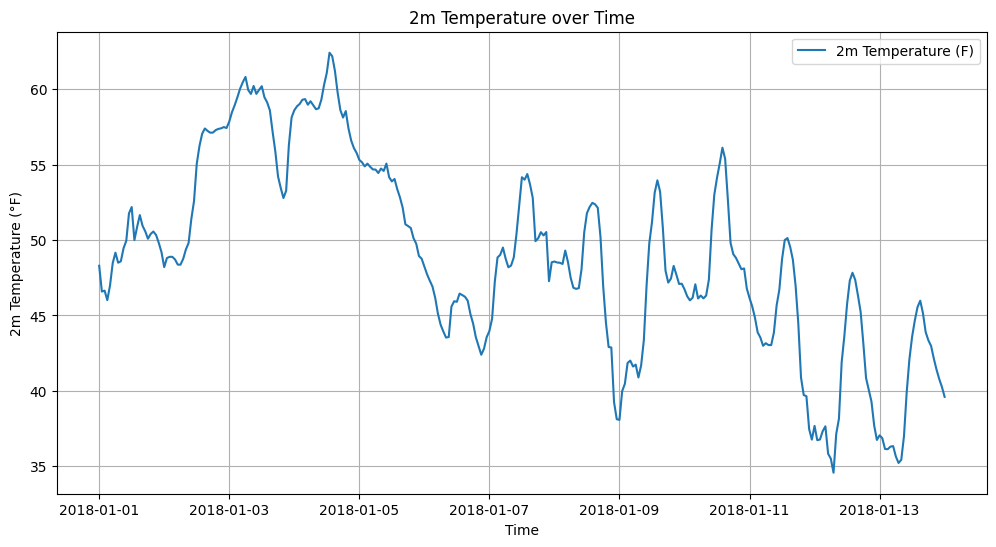

In [10]:
import matplotlib.pyplot as plt

# Plot the 2m_temperature value over time
# Convert temperature from Kelvin to Fahrenheit
t2m_df['2m_temperature_F'] = (t2m_df['2m_temperature'] - 273.15) * 9/5 + 32

plt.figure(figsize=(12, 6))
plt.plot(t2m_df['time'], t2m_df['2m_temperature_F'], label='2m Temperature (F)')
plt.xlabel('Time')
plt.ylabel('2m Temperature (°F)')
plt.title('2m Temperature over Time')
plt.legend()
plt.grid(True)
plt.show()


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ADF Statistic: -1.914027465846842
p-value: 0.3254911946615826
ADF Statistic after differencing: -7.028933704434148
p-value after differencing: 6.258203411185108e-10


/Users/wmorris/github/ai-sprocket/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/wmorris/github/ai-sprocket/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/wmorris/github/ai-sprocket/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/wmorris/github/ai-sprocket/venv/lib/python3.9/site-packages/statsmode

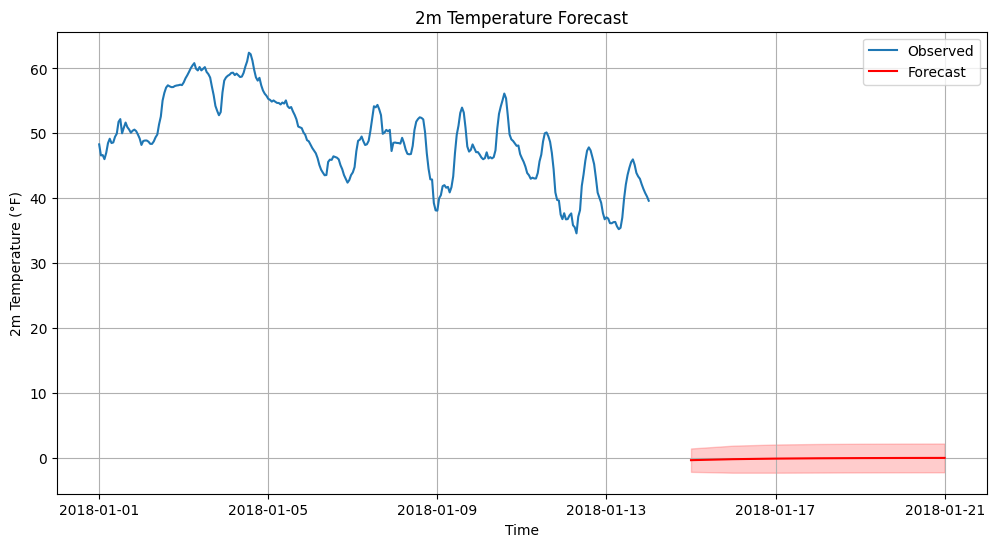

In [14]:
# Install statsmodels for ARIMA
%pip install -q statsmodels

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Check for stationarity using the Augmented Dickey-Fuller test
result = adfuller(t2m_df['2m_temperature_F'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Perform differencing to make the time series stationary
t2m_df['2m_temperature_F_diff'] = t2m_df['2m_temperature_F'].diff()

# Check for stationarity after differencing
result_diff = adfuller(t2m_df['2m_temperature_F_diff'].dropna())
print('ADF Statistic after differencing:', result_diff[0])
print('p-value after differencing:', result_diff[1])

# Fit an ARIMA model to the differenced time series
model = ARIMA(t2m_df['2m_temperature_F_diff'].dropna(), order=(1, 0, 0))
model_fit = model.fit()

# Forecast the next 7 days
forecast = model_fit.get_forecast(steps=7)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create a datetime index for the forecasted values
last_date = t2m_df['time'].iloc[-1]
forecast_dates = [last_date + timedelta(days=i) for i in range(1, 8)]
forecast_mean.index = forecast_dates
forecast_ci.index = forecast_dates

# Plot the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(t2m_df['time'], t2m_df['2m_temperature_F'], label='Observed')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2)
plt.xlabel('Time')
plt.ylabel('2m Temperature (°F)')
plt.title('2m Temperature Forecast')
plt.legend()
plt.grid(True)
plt.show()
